$f_{0}$ extraction using the Pitch Tracking Dataset from TU Graz (PTDBUG)

At first, import packages to be used for the experiments

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import os
import glob
import numpy as np
from tqdm import tqdm
import time
import librosa
import pandas as pd
import seaborn as sns

from joblib import dump, load

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import make_scorer
from pyrcn.metrics import mean_squared_error
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.util import FeatureExtractor
from pyrcn.datasets import fetch_ptdb_tug_dataset
from pyrcn.echo_state_network import SeqToSeqESNRegressor
from pyrcn.base import InputToNode, PredefinedWeightsInputToNode, NodeToNode
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable

import librosa
import librosa.display

Print number of files that are included in the dataset

In [2]:
def create_feature_extraction_pipeline(sr=16000, frame_sizes=[512, 1024]):
    audio_loading = Pipeline([("load_audio", FeatureExtractor(librosa.load, sr=sr, mono=True)),
                              ("normalize", FeatureExtractor(librosa.util.normalize, norm=np.inf))])
    
    feature_extractor = Pipeline([("mel_spectrogram", FeatureExtractor(librosa.feature.melspectrogram, sr=sr, 
                                                                       n_fft=1024, hop_length=160, window='hann',
                                                                       center=False, power=2.0, n_mels=80, 
                                                                       fmin=40, fmax=4000, htk=True)),
                                            ("power_to_db", FeatureExtractor(librosa.power_to_db, ref=1))])

    feature_extraction_pipeline = Pipeline([("audio_loading", audio_loading),
                                            ("feature_extractor", feature_extractor)])
    return feature_extraction_pipeline

## Load and preprocess the dataset

This might require a large amount of time and memory. 

In [3]:
# Load and preprocess the dataset
feature_extraction_pipeline = create_feature_extraction_pipeline()

X_train, X_test, y_train, y_test = fetch_ptdb_tug_dataset(data_origin="Z:/Projekt-Pitch-Datenbank/SPEECH_DATA", 
                                                          data_home=None, preprocessor=feature_extraction_pipeline, 
                                                          force_preprocessing=False)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Feature visualization. All features carry information, since the variance is always large

We can fit a StandardScaler here!

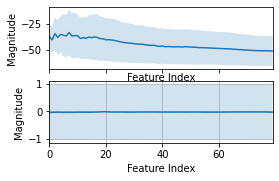

In [4]:
def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(4, 2.5)
tsplot(axs[0], np.concatenate(np.hstack((X_train, X_test))))
axs[0].set_xlabel('Feature Index')
axs[0].set_ylabel('Magnitude')
scaler = StandardScaler().fit(np.concatenate(X_train))
for k, X in enumerate(X_train):
    X_train[k] = scaler.transform(X=X)
for k, X in enumerate(X_test):
    X_test[k] = scaler.transform(X=X)
tsplot(axs[1], np.concatenate(np.hstack((X_train, X_test))))
axs[1].set_xlabel('Feature Index')
axs[1].set_ylabel('Magnitude')
plt.grid()
# plt.savefig('features_statistics.pdf', bbox_inches='tight', pad_inches=0)

Define several error functions for $f_{0}$ extraction

In [5]:
def gpe(y_true, y_pred):
    """
    Gross pitch error:
    
    All frames that are considered voiced by both pitch tracker and ground truth, 
    for which the relative pitch error is higher than a certain threshold (\SI{20}{\percent}).
    
    """
    idx = np.nonzero(y_true*y_pred)[0]
    return np.mean(np.abs(y_true[idx] - y_pred[idx]) > 0.2 * y_true[idx])


def vde(y_true, y_pred):
    """
    Voicing Decision Error:
    
    Proportion of frames for which an incorrect voiced/unvoiced decision is made.
    
    """
    return zero_one_loss(y_true, y_pred)


def fpe(y_true, y_pred):
    """
    Fine Pitch Error:
    
    Standard deviation of the distribution of relative error values (in cents) from the frames
    that do not have gross pitch errors
    """
    idx_voiced = np.nonzero(y_true * y_pred)[0]
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    idx = np.intersect1d(idx_voiced, idx_correct)
    if idx.size == 0:
        return 0
    else:
        return 100 * np.std(np.log2(y_pred[idx] / y_true[idx]))


def ffe(y_true, y_pred):
    """
    $f_{0}$ Frame Error:
    
    Proportion of frames for which an error (either according to the GPE or the VDE criterion) is made.
    FFE can be seen as a single measure for assessing the overall performance of a pitch tracker.
    """
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    return 1 - len(idx_correct) / len(y_true)


def custom_scorer(y_true, y_pred):
    gross_pitch_error = [None] * len(y_true)
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*y_t[:, 1], y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)

gpe_scorer = make_scorer(custom_scorer, greater_is_better=False)

## Set up a ESN

To develop an ESN model for multipitch tracking, we need to tune several hyper-parameters, e.g., input_scaling, spectral_radius, bias_scaling and leaky integration.

We follow the way proposed in the paper for multipitch tracking and for acoustic modeling of piano music to optimize hyper-parameters sequentially.

We define the search spaces for each step together with the type of search (a grid search in this context).

At last, we initialize a SeqToSeqESNRegressor with the desired output strategy and with the initially fixed parameters.

In [6]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage':1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToSeqESNRegressor(**initially_fixed_params)

## Optimization

We provide a SequentialSearchCV that basically iterates through the list of searches that we have defined before. It can be combined with any model selection tool from scikit-learn.

In [7]:
try: 
    sequential_search = load("../sequential_search_f0_mel.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../sequential_search_f0_mel.joblib")

<class 'FileNotFoundError'>
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 168.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 360.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 614.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 770.5min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 140.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 187.6min finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 41.5min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 146.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 200.8min finished


## Visualize hyper-parameter optimization

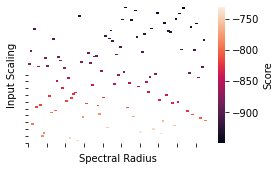

In [8]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
pvt = pd.pivot_table(df, values='mean_test_score', index='param_input_scaling', columns='param_spectral_radius')

pvt.columns = pvt.columns.astype(float)
pvt2 =  pd.DataFrame(pvt.loc[pd.IndexSlice[0:1], pd.IndexSlice[0.0:1.0]])

fig = plt.figure()
ax = sns.heatmap(pvt2, xticklabels=pvt2.columns.values.round(2), yticklabels=pvt2.index.values.round(2), cbar_kws={'label': 'GPE'})
ax.invert_yaxis()
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")
fig.set_size_inches(4, 2.5)
tick_locator = ticker.MaxNLocator(10)
ax.yaxis.set_major_locator(tick_locator)
ax.xaxis.set_major_locator(tick_locator)
# plt.savefig('optimize_is_sr.pdf', bbox_inches='tight', pad_inches=0)

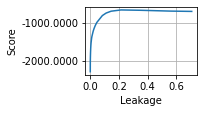

In [9]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage.pdf', bbox_inches='tight', pad_inches=0)

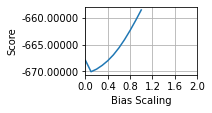

In [10]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 2))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling.pdf', bbox_inches='tight', pad_inches=0)

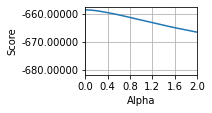

In [11]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_alpha", y="mean_test_score")
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((0, 2))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_beta.pdf', bbox_inches='tight', pad_inches=0)

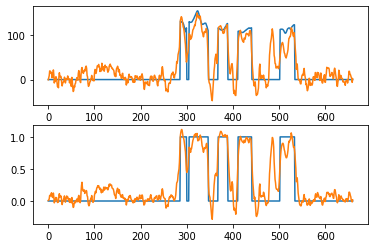

In [12]:
esn = sequential_search.best_estimator_
y_train_pred = esn.predict(X=X_train[0:1])
fig, axs = plt.subplots(2)
axs[0].plot(y_train[0][:, 0], label="f0 ref")
axs[0].plot(y_train_pred[0][:, 0], label="f0 pred")
axs[1].plot(y_train[0][:, 1], label="voicing ref")
axs[1].plot(y_train_pred[0][:, 1], label="voicing pred")

Find the negative examples from training, validation and test sets

In [ ]:
np.argmax(gpe_training), np.argmax(gpe_validation), np.argmax(gpe_test)

Find the positive examples from training, validation and test sets

In [ ]:
np.argmin(gpe_training), np.argmin(gpe_validation), np.argmin(gpe_test)

Visualize worst and best training example

In [ ]:
X, y = extract_features(training_files[323])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(training_files[303])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))

Visualize worst and best validation example

In [ ]:
X, y = extract_features(validation_files[33])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(validation_files[243])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))

Visualize worst and best test example

In [ ]:
X, y = extract_features(test_files[21])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(test_files[368])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))

$K$-Means initialization

In [ ]:
print("Fitting kmeans with features from the training set...")
t1 = time.time()
kmeans = MiniBatchKMeans(n_clusters=50, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
print("done in {0}!".format(time.time() - t1))

Initialize an Echo State Network

In [ ]:
if base_input_to_nodes.hidden_layer_size <=50:
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
else:
    w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, base_input_to_nodes.hidden_layer_size - 50), (0, 0)), mode='constant', constant_values=0)

base_input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T, activation='identity', input_scaling=0.4)

initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage':1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': gpe_scorer}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToSeqESNRegressor(input_to_node=base_input_to_node).set_params(**initially_fixed_params)

Try to load a pre-trained ESN

In [ ]:
try: 
    sequential_search = load("../sequential_search_f0_mel_km.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../sequential_search_f0_mel_km.joblib")

## Visualize hyper-parameter optimization

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
pvt = pd.pivot_table(df, values='mean_test_score', index='param_input_scaling', columns='param_spectral_radius')

pvt.columns = pvt.columns.astype(float)
pvt2 =  pd.DataFrame(pvt.loc[pd.IndexSlice[0:1], pd.IndexSlice[0.0:1.0]])

fig = plt.figure()
ax = sns.heatmap(pvt2, xticklabels=pvt2.columns.values.round(2), yticklabels=pvt2.index.values.round(2), cbar_kws={'label': 'GPE'})
ax.invert_yaxis()
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")
fig.set_size_inches(4, 2.5)
tick_locator = ticker.MaxNLocator(10)
ax.yaxis.set_major_locator(tick_locator)
ax.xaxis.set_major_locator(tick_locator)
# plt.savefig('optimize_is_sr.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 2))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_alpha", y="mean_test_score")
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((0, 2))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_beta.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
esn = sequential_search.best_estimator_
y_train_pred = esn.predict(X=X_train[0:1])
fig, axs = plt.subplots(2)
axs[0].plot(y_train[0][:, 0], label="f0 ref")
axs[0].plot(y_train_pred[0][:, 0], label="f0 pred")
axs[1].plot(y_train[0][:, 1], label="voicing ref")
axs[1].plot(y_train_pred[0][:, 1], label="voicing pred")

Find the negative examples from training, validation and test sets

In [ ]:
np.argmax(gpe_training), np.argmax(gpe_validation), np.argmax(gpe_test)

Find the positive examples from training, validation and test sets

In [ ]:
np.argmin(gpe_training), np.argmin(gpe_validation), np.argmin(gpe_test)

Visualize worst and best training example

In [ ]:
X, y = extract_features(training_files[323])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(training_files[303])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))

Visualize worst and best validation example

In [ ]:
X, y = extract_features(validation_files[33])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(validation_files[243])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))

Visualize worst and best test example

In [ ]:
X, y = extract_features(test_files[21])
y_pred = esn.predict(X=X)
plt.subplot(2,1,1)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))
X, y = extract_features(test_files[368])
y_pred = esn.predict(X=X)
plt.subplot(2,1,2)
plt.plot(y[:, 0])
plt.plot(y_pred[:, 0]*(y_pred[:, 1] >= .5))